# Pupilometria - Binarização Global

Autor: Matheus Felipe Bosa

---

## Preparação dos Dados

Importando pasta pessoal do Google Drive contendo as imagens do dataset.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importando as bibliotecas utilizadas neste experimento.

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')

import numpy as np

from skimage import io
from skimage import img_as_float, img_as_ubyte

from skimage.color import rgb2gray, label2rgb

from skimage.morphology import square 
from skimage.morphology import erosion, dilation, opening, closing

from skimage.filters import gaussian as gaussian_filter
from skimage.filters import sobel, sobel_v, sobel_h
from skimage.filters import scharr, scharr_v, scharr_h
from skimage.filters import prewitt, prewitt_v, prewitt_h
from skimage.filters.rank import mean as mean_filter, median as median_filter

from skimage.exposure import rescale_intensity, equalize_hist
from skimage.exposure import equalize_adapthist, cumulative_distribution

from skimage.draw import circle, circle_perimeter
from skimage.measure import regionprops, label as measure_label

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Definindo funções para plotagem de imagens.

In [0]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))
    ax.imshow(img_as_float(image), cmap='gray')
    return fig, ax

def image_show_all(*images, titles=None, cmap='gray'):
    images = [img_as_float(image) for image in images]

    if titles is None:
        titles = [''] * len(images)

    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 6
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
        ax.set_title(label)

Carregando uma imagem de pupilometria de um paciente.

*   Paciente: 12
*   Coleta: 2

Type: <class 'numpy.ndarray'>
Data type: float64
Shape: (480, 640)
Min/Max: 0.09609764705882354 0.9706074509803921


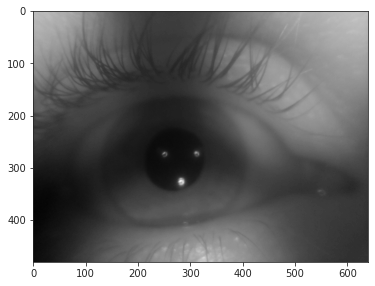

In [7]:
path = '...'
folder = '41/'
subfolder = '41_2/'
frame = 'frame_0149'
filename = path + folder + subfolder + frame + '.jpg'

original = rgb2gray(io.imread(filename))

print('Type:', type(original))
print('Data type:', original.dtype)
print('Shape:', original.shape)
print('Min/Max:', original.min(), original.max())

image_show(original);

---

## Pré-Processamento

Removendo ruído na imagem original e comparando alguns filtros.

In [8]:
selem = square(width=7)
print('Elemento estruturante:\n', selem)

Elemento estruturante:
 [[1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]


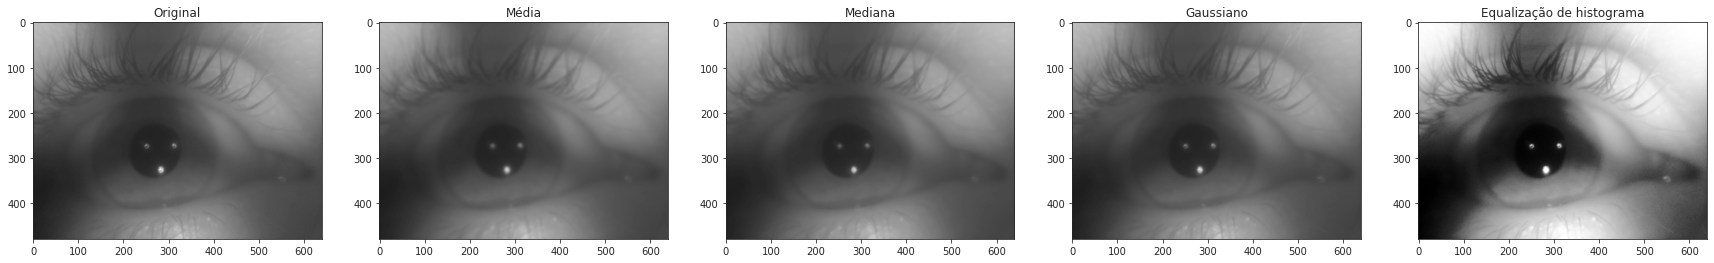

In [15]:
mean = mean_filter(img_as_ubyte(original), selem)
median = median_filter(img_as_ubyte(original), selem)
gaussian = gaussian_filter(original, sigma=1)

image_show_all(original, mean, median, gaussian, eq_hist,
               titles=['Original', 'Média', 'Mediana', 'Gaussiano', 'Equalização de histograma']);

Experimentando filtros com base em histograma.

In [0]:
def plot_img_and_hist(img, axes, bins=256):
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Mostra a imagem
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Mostra o histograma
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Intensidade')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Mostra a distribuição cumulativa
    img_cdf, bins = cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [0]:
# Alongamento de constraste
p2, p98 = np.percentile(original, (2, 98))
contrast = rescale_intensity(original, in_range=(p2, p98))

# Equalização de histograma
eq_hist = equalize_hist(original)

# Equalização de histograma adaptativa
adapt_eq_hist = equalize_adapthist(original, clip_limit=0.03)

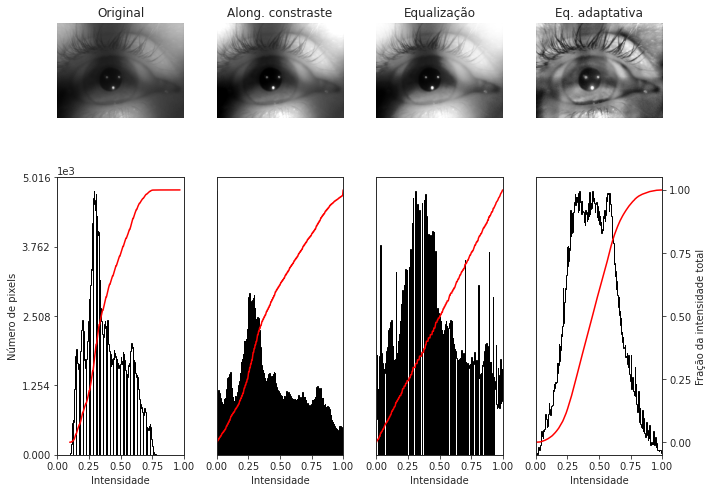

In [12]:
# Mostrando os resultados
fig = plt.figure(figsize=(10, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0, 0], sharey=axes[0, 0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(original, axes[:, 0])
ax_img.set_title('Original')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Número de pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(contrast, axes[:, 1])
ax_img.set_title('Along. constraste')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(eq_hist, axes[:, 2])
ax_img.set_title('Equalização')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(adapt_eq_hist, axes[:, 3])
ax_img.set_title('Eq. adaptativa')

ax_cdf.set_ylabel('Fração da intensidade total')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# Sem overlap nos rótulos do eixo y
fig.tight_layout();

---

### Removendo Reflexos Especulares

O conjunto de LEDs infravermelhos usados para iluminação do olho durante a gravação dos vídeos gera reflexos especulares em sua superfície, que aparecem na imagem como pontos claros sobre a pupila.

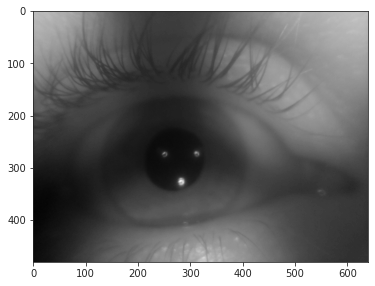

In [13]:
image_show(original);

In [0]:
def change_value_neighborhood(img, pixel, L):
  r, c = pixel[0], pixel[1]
  
  # Acha as coordenadas de um círculo de raio L centrado em (x, y)
  r_coords, c_coords = circle(r, c, L, img.shape)

  # Calcula o valor mínimo entre todos os pixel localizados a uma distância menor que L 
  new_value = img[r_coords, c_coords].min()

  # Substitui o pixel e seus vizinhos pelo novo valor
  img[r_coords, c_coords] = new_value
  return

def mean_value_neighborhood(img, pixel):
  r, c = pixel[0], pixel[1]
  return np.mean([img[r, c], img[r+1, c], img[r-1, c], img[r, c+1], img[r, c-1]])

def remove_flashes(img, L=6, k=1.5):
  print('Removendo reflexos especulares...')
  
  lim_min, lim_row_max, lim_col_max, = L+1, img.shape[0]-L-1, img.shape[1]-L-1

  # Para cada pixel (x, y)
  for r in range(lim_min, lim_row_max):
    for c in range(lim_min, lim_col_max):
      # Calcula o valor médio entre o pixel e sua 4-vizinhança
      v0 = mean_value_neighborhood(img, pixel=(r, c))
     
      # Calcula o valor médio dos pixels L distantes
      vr = mean_value_neighborhood(img, pixel=(r+L, c))
      vl = mean_value_neighborhood(img, pixel=(r-L, c))
      vu = mean_value_neighborhood(img, pixel=(r, c+L))
      vd = mean_value_neighborhood(img, pixel=(r, c-L))

      # Verifica se pixel está próximo ao centro do artefato a ser removido
      change_pixel = (v0 > vr*k) and (v0 > vl*k) and (vu > vr*k) and (vd > vr*k)
      if change_pixel:
        print('Artefato no pixel:', (r, c))
        change_value_neighborhood(img, (r, c), L)
  
  return img

O parâmetro **L** é ajustado de acordo com o raio dos artefatos que se deseja eliminar. Um valor muito alto pode levar a detecções incorretas e alterações indesejadas na imagem, enquanto um valor baixo poderia reduzir a eficácia do método ao ignorar um ou mais reflexos.

A relação **k** é obtida pela análise dos níveis de cinza dos artefatos e das regiões próximas nas imagens. Um valor baixo pode levar à identificação incorreta de artefatos, enquanto um valor elevado faz com que alguns reflexos sejam ignorados.

Removendo reflexos especulares...
Artefato no pixel: (97, 207)
Artefato no pixel: (201, 158)
Artefato no pixel: (202, 261)
Artefato no pixel: (207, 166)
Artefato no pixel: (208, 256)
Artefato no pixel: (231, 207)
Artefato no pixel: (237, 179)
Artefato no pixel: (241, 202)
Artefato no pixel: (245, 184)


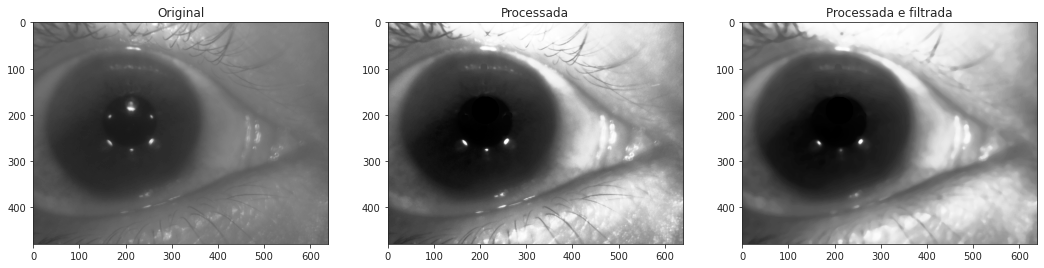

In [0]:
# Processando a imagem com histograma equalizado
flashes_removed = eq_hist.copy()

# L e k definidos empiricamente
L = 8
k = 1.5
remove_flashes(flashes_removed, L, k)

rr, cc = circle(r=190, c=210, radius=30, shape=flashes_removed.shape)
flashes_removed[rr, cc] = 0

flashes_removed_final = median_filter(img_as_ubyte(flashes_removed), square(L))


image_show_all(original, flashes_removed, flashes_removed_final, 
               titles=['Original', 'Processada', 'Processada e filtrada']);

---

## Segmentação da Pupila

### Binarização Global da Imagem


Determinação do limiar que demarca a pupila a partir do histograma da imagem.

Limiar: 6.375


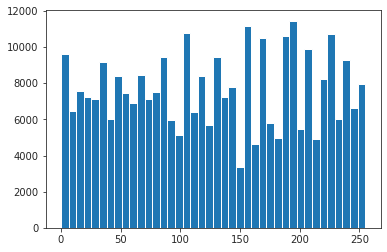

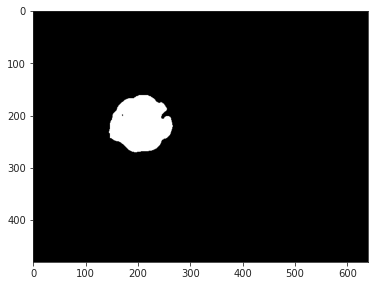

In [0]:
seg_pupil = flashes_removed_final.copy()

n_bins = 40 # n_bins definido empiricamente
hist, bins = np.histogram(seg_pupil.ravel(), n_bins)
t = bins[1]

print('Limiar:', t)
plt.hist(seg_pupil.ravel(), bins=n_bins)
plt.show()

thresh = img_as_float(seg_pupil < t)

image_show(thresh);

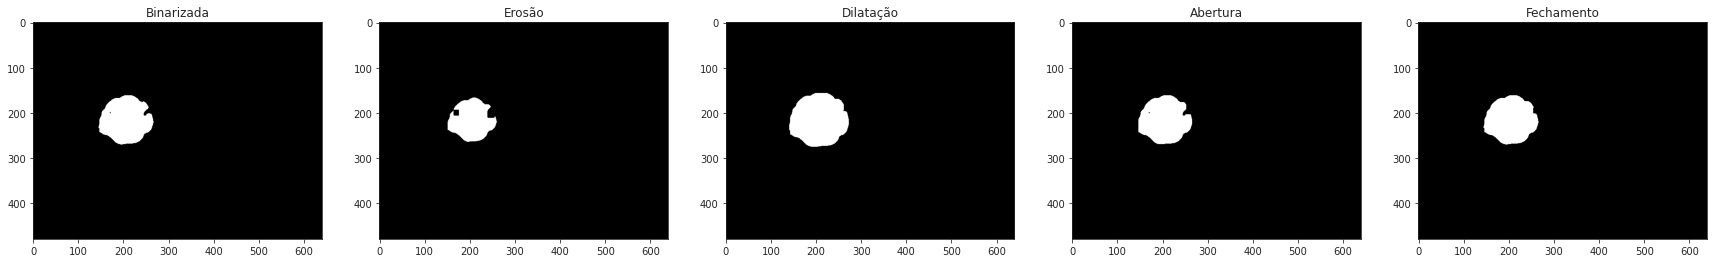

In [0]:
selem_morph = square(11)

eroded = erosion(thresh, selem_morph)
dilated = dilation(thresh, selem_morph)
opened = opening(thresh, selem_morph)
closed = closing(thresh, selem_morph)

image_show_all(thresh, eroded, dilated, opened, closed,
               titles=['Binarizada', 'Erosão', 'Dilatação', 'Abertura', 'Fechamento']);

Rotulando a imagem binarizada.

Número de regiões: 1


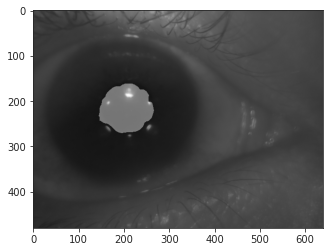

In [0]:
labels, n_labels = measure_label(closed, background=0, return_num=True)

print('Número de regiões:', n_labels)
labels_colored = label2rgb(labels, image=original, colors=['black', 'white'], alpha=0.4)

plt.imshow(labels_colored)
plt.show()

Encontrando centroide e aproximando a região segmentada da pupila a uma circunferência.

In [0]:
pupil = original.copy()

regions = regionprops(labels)
region = max(regions, key=lambda item: item.area)
  
row_p, col_p = map(int, region.centroid)
# Aproximando região a uma circunferência
radius_p = int(np.sqrt(region.area / np.pi))

r_coords_pupil, c_coords_pupil = circle(row_p, col_p, radius_p, shape=pupil.shape)
pupil[r_coords_pupil, c_coords_pupil] = 1

Plotando a marcação da pupila.

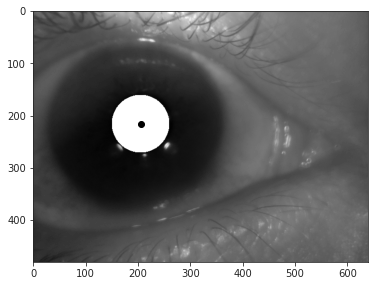

In [0]:
fig, ax = image_show(pupil)
ax.plot(col_p, row_p, 'ko');

Mostrando a posição da pupila.

In [0]:
print('Pupila (Histograma):', row_p, col_p, radius_p)

Pupila (Histograma): 216 205 55


---

## Segmentação da Íris

Encontrando o valor no eixo Ox que define a transição da íris para a esclera.

In [0]:
seg_iris = flashes_removed_final.copy()

edge_sobel = sobel(seg_iris)
edge_sobel_h = sobel_h(seg_iris)
edge_sobel_v = sobel_v(seg_iris)
edge_scharr = scharr(seg_iris)
edge_scharr_h = scharr_h(seg_iris)
edge_scharr_v = scharr_v(seg_iris)
edge_prewitt = prewitt(seg_iris)
edge_prewitt_h = prewitt_h(seg_iris)
edge_prewitt_v = prewitt_v(seg_iris)

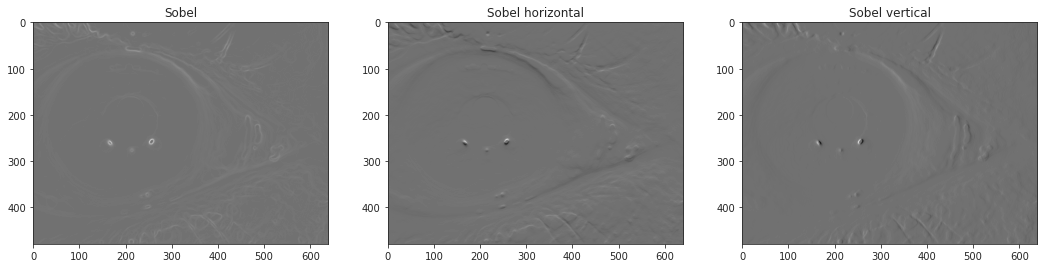

In [0]:
image_show_all(edge_sobel, edge_sobel_h, edge_sobel_v, titles=['Sobel', 'Sobel horizontal', 'Sobel vertical']);

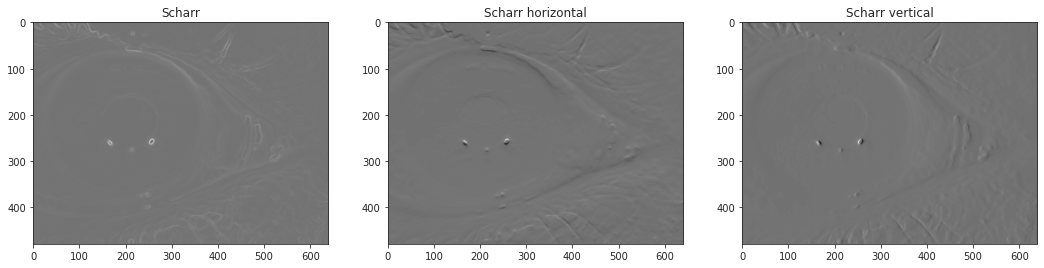

In [0]:
image_show_all(edge_scharr, edge_scharr_h, edge_scharr_v, titles=['Scharr', 'Scharr horizontal', 'Scharr vertical']);

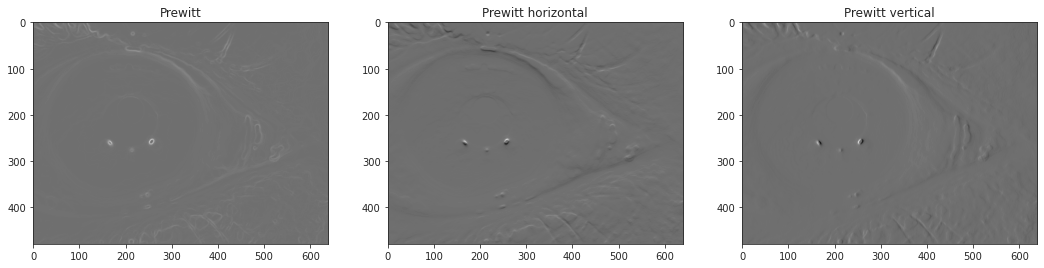

In [0]:
image_show_all(edge_prewitt, edge_prewitt_h, edge_prewitt_v, titles=['Prewitt', 'Prewitt horizontal', 'Prewitt vertical']);

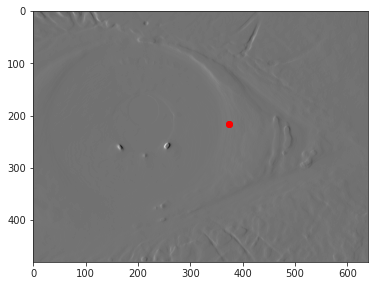

In [0]:
seg_iris = edge_scharr_v.copy()
# seg_iris = edge_sobel_v.copy()

a = 20
b = 120
offset_col = col_p + radius_p + a

gradient_col = np.gradient(seg_iris[row_p, offset_col:offset_col+b])

col_edge = np.argmax(gradient_col) + offset_col

fig, ax = image_show(seg_iris)
ax.plot(col_edge, row_p, 'ro')
ax.plot(col_edge, row_p, 'ro')

In [0]:
iris = original.copy()

radius_i = col_edge - col_p
row_i = row_p
col_i = col_p

r_coords_iris, c_coords_iris = circle_perimeter(row_i, col_i, radius_i)
iris[r_coords_iris, c_coords_iris] = 1

Plotando a marcação da íris.

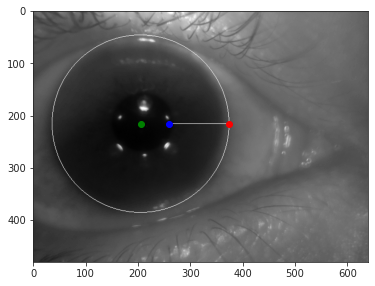

In [0]:
iris[rr, cc] = 1

fig, ax = image_show(iris)
ax.plot(col_i, row_i, 'go');
ax.plot(col_i+radius_p, row_i, 'bo');
ax.plot(col_edge, row_p, 'ro');

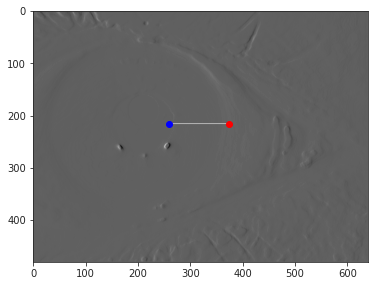

In [0]:
from skimage.draw import line

rr, cc = line(row_p, col_p+radius_p, row_i, col_edge)
seg_iris[rr, cc] = 1

fig, ax = image_show(seg_iris)
ax.plot(col_i+radius_p, row_i, 'bo');
ax.plot(col_edge, row_p, 'ro')

Mostrando a posição da íris.

In [0]:
print('Íris:', row_i, col_i, radius_i)

Íris: 219 203 167


---

## Resultado Final

Pupila: 219 203 54
Íris: 219 203 167


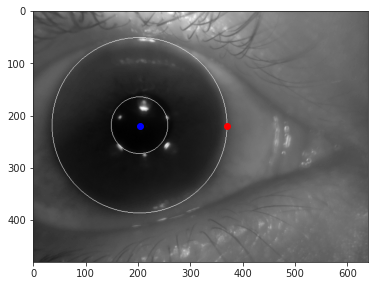

In [0]:
segmented = original.copy()

segmented[r_coords_pupil, c_coords_pupil] = 1
segmented[r_coords_iris, c_coords_iris] = 1

fig, ax = image_show(segmented)
ax.plot(col_p, row_p, 'bo');
ax.plot(col_edge, row_p, 'ro');

print('Pupila:', row_p, col_p, radius_p)
print('Íris:', row_i, col_i, radius_i)